In [1]:
from DatabaseConnections import *
import params
import pandas as pd
import cPickle as cpickle
import itertools
import math
import os
import csv
import progressbar
from operator import itemgetter
from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt
import folium
# clear_output()

STARTING...



In [14]:
db = PostgresDb(params.DB_HOST, params.DB_NAME) 

clear_output()
print 'Connected to database {}'.format(params.DB_NAME)

Connected to database RIS_TRAINING


### Cleanup any files from previous run
#### -- This will delete old data --

In [3]:
@timeDec
def reset(db, version):
    tables = ['node_stnameft', 'lion', 'node', 'c_master_node',
              'c_master_segs', 'C_Lion_%s' % version, 'C_Lion_Nodes_%s' % version, 'm']
    for t in tables:
        print 'Droping %s\n' % t
        db.query("DROP TABLE if exists %s" % t)
    return raw_input('Re-imported lion and nodes? <enter>\n').upper()

@timeDec
def reset_current_version(db, version):
    tables = ['node_stnameft', 'c_master_node',
              'c_master_segs', 'C_Lion_%s' % version, 'C_Lion_Nodes_%s' % version, 'm']
    for t in tables:
        print 'Droping %s\n' % t
        db.query("DROP TABLE if exists %s" % t)
    # clean up exsiting tables 
    db.query("alter table lion drop column version")
    db.query("alter table lion drop column exclude")
    db.query("alter table lion drop column mft")
    db.query("alter table lion drop column masteridfrom")
    db.query("alter table lion drop column masteridto")
    
    db.query("alter table node drop column version")
    db.query("alter table node drop column masterid")
    db.query("alter table node drop column is_int")
    print 'Done...'

In [4]:
# clean out old versions of lion ?

if raw_input('Delete and reimport old LION (1) or clean up existing LION (2)') == '1':
    reset(db, params.VERSION)
else:
    reset_current_version(db, params.VERSION)

Delete and reimport old LION (1) or clean up existing LION (2)2
Droping node_stnameft

Update sucessfull
Droping c_master_node

Update sucessfull
Droping c_master_segs

Update sucessfull
Droping C_Lion_16d

Update sucessfull
Droping C_Lion_Nodes_16d

Update sucessfull
Droping m

Update sucessfull
Query Failed:

	alter table lion drop column version
Query Failed:

	alter table lion drop column exclude
Query Failed:

	alter table lion drop column mft
Query Failed:

	alter table lion drop column masteridfrom
Query Failed:

	alter table lion drop column masteridto
Query Failed:

	alter table node drop column version
Query Failed:

	alter table node drop column masterid
Query Failed:

	alter table node drop column is_int
Done...
'reset_current_version' 0.04 sec


### Import Roadbed Pointer List into database

In [5]:
def read_file(file_path):
    with open(file_path, 'r') as f:
        read_data = f.read()
    return read_data

def split_to_rows(raw_data):
    d = raw_data.split('\n')
    output = []
    for row in d:
        output.append(row.split(','))
    return output

def split_to_columns(data_rows):
    data = []
    # ['RPL_ID', 'SegmentIDG', 'SegmentIDR', 'RPC', 'NCI',
    #         'NodeLevelF', 'NodeLevelT', 'R_FrNd', 'G_FrNd', 'R_ToNd', 'G_ToNd']
    idn = 0
    for row in data_rows:
        if row != ['']:
            # print row
            idn += 1
            g_seg = row[0][:7]
            g_seg_typ = row[0][7]
            r_seg = row[0][8:15]
            rpc = row[0][16]
            nci = row[0][18]
            fnode_level_code = row[0][22]
            tnode_level_code = row[0][26]
            f_node_rb_seg = row[0][28:35]
            f_node_g_seg = row[0][36:43]
            t_node_rb_seg = row[0][44:51]
            t_node_g_seg = row[0][52:59]
            data.append([idn, g_seg, r_seg, rpc, nci, fnode_level_code, tnode_level_code,
                         f_node_rb_seg, f_node_g_seg, t_node_rb_seg, t_node_g_seg])
    return data

def add_to_db(db, rpl, data):
    # make sure table exists and is clean
    db.query("""DROP TABLE if exists {0};
                    CREATE TABLE {0}
                    (
                      rpl_id bigint, segmentidg bigint, segmentidr bigint,
                      rpc character varying(1), nci character varying(1),
                      nodelevelf character varying(1), nodelevelt character varying(1),
                      r_frnd bigint, g_frnd bigint, r_tond bigint, g_tond bigint
                    );
                """.format(rpl))
    for row in data:
        if row[0] != 'RPL_ID':
            add_row(db, row)


def add_row(db, row):
    if row[0]:
        db.query("""INSERT INTO tbl_rpl (rpl_id, segmentidg, segmentidr, rpc, nci,nodelevelf,
                        nodelevelt, r_frnd, g_frnd, r_tond, g_tond)
                        VALUES (%s);
                    """ % str(row)[1:-1])
        print 'Added %s' % row[0]
        clear_output()

In [6]:
@timeDec
def add_rpl(db):
    r_data = read_file(os.path.join(params.FOLDER, params.RPL_TXT))
    dta = split_to_rows(r_data)
    split_data = split_to_columns(dta)
    add_to_db(db, params.RPL, split_data)

add_rpl(db)
query_to_table(db, "select * from {} limit 10".format(params.RPL))

'add_rpl' 142.68 sec


,rpl_id,segmentidg,segmentidr,rpc,nci,nodelevelf,nodelevelt,r_frnd,g_frnd,r_tond,g_tond
0,1,603,152742,R,B,,,87191,436,87224,427
1,2,603,143668,L,B,,,94522,436,94515,427
2,3,611,152783,R,B,,,86306,446,87191,436
3,4,611,143667,L,B,,,94529,446,94522,436
4,5,668,152704,R,B,,,87106,492,87107,494
5,6,668,152780,L,B,,,87138,492,88593,494
6,7,670,152859,R,B,,,87107,494,88567,497
7,8,670,150838,L,B,,,88593,494,496,497
8,9,674,150841,R,B,,,88567,497,88590,498
9,10,674,144716,L,B,,,496,497,86315,498


In [7]:
@timeDec
def save_dictionaries(io='OUT'):
    """write out the data in dictionaries, may only be useful for testing..."""
    if io == 'OUT':
        cpickle.dump(params.nodeStreetNames, open(os.path.join(params.FOLDER, "nodeStreetNames.p"), "wb"))
        cpickle.dump(params.nodeIsIntersection, open(os.path.join(params.FOLDER, "nodeIsIntersection.p"), "wb"))
        cpickle.dump(params.nodeNextSteps, open(os.path.join(params.FOLDER, "nodeNextSteps.p"), "wb"))
        cpickle.dump(params.segmentBlocks, open(os.path.join(params.FOLDER, "segmentBlocks.p"), "wb"))
        cpickle.dump(params.node_master, open(os.path.join(params.FOLDER, "nodeMaster.p"), "wb"))
        cpickle.dump(params.clusterIntersections, open(os.path.join(params.FOLDER, "clusterIntersections.p"), "wb"))
        cpickle.dump(params.streetSet, open(os.path.join(params.FOLDER, "streetSet.p"), "wb"))
        cpickle.dump(params.mft1Dict, open(os.path.join(params.FOLDER, "mft1Dict.p"), "wb"))
        cpickle.dump(params.altGraph, open(os.path.join(params.FOLDER, "altGraph.p"), "wb"))
        cpickle.dump(params.mfts, open(os.path.join(params.FOLDER, "mfts.p"), "wb"))
        cpickle.dump(params.coordFromMaster, open(os.path.join(params.FOLDER, "coordFromMaster.p"), "wb"))
    else:
        d1 = cpickle.load(open(os.path.join(params.FOLDER, "nodeStreetNames.p"), "rb"))
        d2 = cpickle.load(open(os.path.join(params.FOLDER, "nodeIsIntersection.p"), "rb"))
        d3 = cpickle.load(open(os.path.join(params.FOLDER, "nodeNextSteps.p"), "rb"))
        d4 = cpickle.load(open(os.path.join(params.FOLDER, "segmentBlocks.p"), "rb"))
        d5 = cpickle.load(open(os.path.join(params.FOLDER, "nodeMaster.p"), "rb"))
        d6 = cpickle.load(open(os.path.join(params.FOLDER, "clusterIntersections.p"), "rb"))
        d7 = cpickle.load(open(os.path.join(params.FOLDER, "streetSet.p"), "rb"))
        d8 = cpickle.load(open(os.path.join(params.FOLDER, "mft1Dict.p"), "rb"))
        d9 = cpickle.load(open(os.path.join(params.FOLDER, "altGraph.p"), "rb"))
        d10 = cpickle.load(open(os.path.join(params.FOLDER, "mfts.p"), "rb"))
        d11 = cpickle.load(open(os.path.join(params.FOLDER, "coordFromMaster.p"), "rb"))
        return d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11

# Preprocess 
## Set up data schema

In [8]:
@timeDec
def pre_process(db, lion, node, version, highways=False):
    print 'Adding version number (%s)...\n' % version
    db.query("alter table %s add version varchar(50)" % lion)
    db.query("alter table %s add version varchar(50)" % node)
    db.query("update %s set version  = '%s'" % (lion, version))
    db.query("update %s set version  = '%s'" % (node, version))
    # add field for exclusion
    db.query("alter table %s add exclude int" % lion)
    db.query("update %s set exclude  = 1" % (lion)) # exclude everything
    
    print 'Adding master ID fields to tables...\n'
    db.query("alter table %s add column mft int, add column masteridfrom int, add column masteridto int" % lion)
    db.query("alter table %s add column masterid int" % node)
    db.query("alter table %s add column is_int int" % node)
    
    print 'Creating node street name table (highways = %s)...\n' % str(highways)
    if highways:
        db.query("""
                update {0} set exclude = 0  
                where rb_layer in ('B', 'G') and featuretyp in ('0', '6', 'C') 
                and (nonped = 'D' or nonped is null)
                and trafdir != 'P' and rw_type!='7' -- take out ped streets (not including step streets)
                and street != 'UNNAMED STREET' 
                and street not like '%{1}%' and street not like '%{2}%'  and street not like '%{3}%'
                """.format(lion, 'PED OVPS', 'PEDESTRIAN OVERPASS', 'PEDESTRIAN UNDERPASS'))
        
        db.query("""
                update {0} set exclude = 0  
                where rb_layer in ('B', 'G') and featuretyp in ('0', '6', 'C') 
                and (nonped = 'V' and street = 'PELHAM PARKWAY')
                and trafdir != 'P' and rw_type!='7' -- take out ped streets (not including step streets)
                and street != 'UNNAMED STREET' 
                and street not like '%{1}%' and street not like '%{2}%' and street not like '%{3}%'
                """.format(lion, 'PED OVPS', 'PEDESTRIAN OVERPASS', 'PEDESTRIAN UNDERPASS'))
        
        db.query("""
                update {0} set exclude = 0  
                where nonped = 'V' and rb_layer in ('B', 'G') and street = 'EAST FORDHAM ROAD'
                """.format(lion))
        
        db.query("""
                update {0} set exclude = 0  
                where rb_layer in ('B', 'G') and featuretyp in ('0', '6', 'C') 
                and (nonped = 'V' and street = 'ROCKAWAY FREEWAY')
                and street != 'UNNAMED STREET' 
                and street not like '%{1}%' and street not like '%{2}%'  and street not like '%{3}%'
                """.format(lion, 'PED OVPS', 'PEDESTRIAN OVERPASS', 'PEDESTRIAN UNDERPASS'))
        
        db.query("""drop table if exists node_stnameFT;
                    create table node_stnameFT as (
                    select node::int, street, 0 as master from (
                        select nodeidfrom as node, street
                        from {0} where exclude = 0
                        group by nodeidfrom, street

                        union

                        select nodeidto as node, street
                        from {0} where exclude = 0
                        group by nodeidto, street
                    ) as included );""".format(lion))
    else:
        db.query("""update {0} set exclude = 0  
                where rb_layer in ('B', 'G') and featuretyp in ('0', '6', 'C')
                and trafdir != 'P' and rw_type!='7' -- take out ped streets (not including step streets)
                and street != 'UNNAMED STREET' 
                and street not like '%{1}%' and street not like '%{2}%'  and street not like '%{3}%'
                """.format(lion, 'PED OVPS', 'PEDESTRIAN OVERPASS', 'PEDESTRIAN UNDERPASS'))
        
        db.query("""drop table if exists node_stnameFT;
                    create table node_stnameFT as (
                    select node::int, street, 0 as master
                    from (
                        select nodeidfrom as node, street
                        from {0}
                        where where exclude = 0
                        group by nodeidfrom, street

                        union

                        select nodeidto as node, street
                        from {0}
                        where where exclude = 0
                        group by nodeidto, street
                        ) ft
                    group by node, street)
                """.format(lion))
# Run preprocess
pre_process(db, params.LION, params.NODE, params.VERSION, params.HIGHWAYS)
# Check resutls


Adding version number (16d)...

Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Adding master ID fields to tables...

Update sucessfull
Update sucessfull
Update sucessfull
Creating node street name table (highways = True)...

Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
'pre_process' 349.59 sec


In [9]:
query_to_table(db, "select * from node_stnameFT limit 10")

,node,street,master
0,60452,32 AVENUE,0
1,55416,MAPLE AVENUE,0
2,79493,EAST GUN HILL ROAD,0
3,29003,VERMONT STREET,0
4,32007,103 STREET,0
5,7931,CROMWELL CIRCLE,0
6,30658,BEACH 144 STREET,0
7,20077,GREENWICH STREET,0
8,73860,CHRISTIE AVENUE,0
9,44007,MACOMBS ROAD,0


# Part 2
### Build data dictionaries

In [10]:
def de_suffix(name):  # todo fix e as part of east example
    """cleans up street names for less percise matches"""
    d = {' WEST': ' DIR', ' EAST': ' DIR',
         ' SOUTH': ' DIR', ' NORTH': ' DIR',
         ' EXIT': ' DIR', ' ENTRANCE': ' DIR',
         ' APPROACH': ' DIR', ' NORTHBOUND': ' DIR',
         ' SOUTHBOUND': ' DIR', ' EASTBOUND': ' DIR',
         ' WESTBOUND': ' DIR'}  # new needs to be tested!!!!
    for i in d:
        if name not in ('WEST STREET', 'SOUTH STREET', 'NORTH STREET', 'EAST STREET',
                        'WEST AVENUE', 'SOUTH AVENUE', 'NORTH AVENUE', 'EAST AVENUE',
                        'WEST BOULEVARD', 'SOUTH BOULEVARD', 'NORTH BOULEVARD', 'EAST BOULEVARD',
                        'WEST LOOP', 'SOUTH LOOP', 'NORTH LOOP', 'EAST LOOP',
                        'WEST DRIVE', 'SOUTH DRIVE', 'NORTH DRIVE', 'EAST DRIVE',
                        'WEST ROAD', 'SOUTH ROAD', 'NORTH ROAD', 'EAST ROAD',
                        'JUNIPER BOULEVARD NORTH', 'JUNIPER BOULEVARD SOUTH'
                        'PROSPECT PARK WEST', 'AVENUE N', 'AVENUE S', 'AVENUE E',
                        'AVENUE W',):
            name = name.replace(i, d[i])
    return name 
    
@timeDec
def node_names(db, nodeStreetNames):
    data = db.query("select * from node_stnameFT")
    bar = progressbar.ProgressBar()
    for row in bar(data[0]):
        node, street = row[0], de_suffix(row[1])
        if node not in nodeStreetNames.keys():
            nodeStreetNames[node] = set([street])
        else:
            nodeStreetNames[node].add(street)
    return nodeStreetNames

params.nodeStreetNames = {}
params.nodeStreetNames = node_names(db, params.nodeStreetNames)

'node_names' 128.34 sec


100% |########################################################################|


In [11]:
@timeDec
def intersection_binary_temp(db, node_table, lion):
    """Updates the is_int field in db"""
    db.query("drop table if exists temp_int;")
    db.query("""create table temp_int as (
                    select nodeid, is_int, count(*) as cnt
                    from (
                        select nodeid, is_int, street
                        from {0} n join {1} l 
                        on n.nodeid::int = l.nodeidfrom::int 
                        where exclude = 0
                        union
                        select nodeid, is_int, street
                        from {0} n join {1} l 
                        on n.nodeid::int = l.nodeidto::int
                        where exclude = 0                        
                    ) as base
                    group by nodeid, is_int
                    having count(*) >1
                );""".format(node_table, lion))
    db.query("update {0} set is_int = -1 from temp_int where {0}.nodeid=temp_int.nodeid;".format(node_table))
    db.query("drop table temp_int;")  

intersection_binary_temp(db, params.NODE, params.LION)



Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
'intersection_binary_temp' 7.11 sec


In [12]:
@timeDec
def intersection_highway_ramp_fix(db, node_table, lion):

    # create highway ramp intersection table
    db.query("""
               drop table if exists ramp_ints;
                create table ramp_ints as 
                select nodeidfrom, nodelevelf, count(*) 
                from (
                    select nodeidfrom, nodelevelf, nonped from {0} 
                    where featuretyp in ('0', '6', 'C') and rb_layer in ('B','G') -- centerline vehicle only streets
                    and street != 'UNNAMED STREET' and street not like '%PED OVPS%' and street not like '%PEDESTRIAN OVERPASS%'
                    and exclude = 0
                    union select nodeidto, nodelevelt, nonped from {0} 
                    where featuretyp in ('0', '6', 'C') and rb_layer in ('B','G') -- centerline vehicle only streets
                    and street != 'UNNAMED STREET' and street not like '%PED OVPS%' and street not like '%PEDESTRIAN OVERPASS%'
                    and exclude = 0
                    
                    union
                     select nodeidfrom, nodelevelf, nonped from {0} 
                    where featuretyp in ('0', '6', 'C') and rb_layer in ('B','G') -- centerline vehicle only streets
                    and street != 'UNNAMED STREET' and street not like '%PED OVPS%' and street not like '%PEDESTRIAN OVERPASS%'
                    and rw_type = '9'
                    union select nodeidto, nodelevelt, nonped from {0} 
                    where featuretyp in ('0', '6', 'C') and rb_layer in ('B','G') -- centerline vehicle only streets
                    and street != 'UNNAMED STREET' and street not like '%PED OVPS%' and street not like '%PEDESTRIAN OVERPASS%'
                    and rw_type = '9'
                    
                    -- special case for error in LION 16D !!!!
                    union 
                    select nodeidfrom, nodelevelf, nonped from {0} 
                    where featuretyp in ('0', '6', 'C') and rb_layer in ('B','G') -- centerline vehicle only streets
                    and street in ('QUEENS MIDTOWN TUNNEL APPROACH', 'QUEENS MIDTOWN TUNNEL EXIT')
                    union select nodeidto, nodelevelt, nonped from {0} 
                    where featuretyp in ('0', '6', 'C') and rb_layer in ('B','G') -- centerline vehicle only streets
                    and street in ('QUEENS MIDTOWN TUNNEL APPROACH', 'QUEENS MIDTOWN TUNNEL EXIT')
                    -- special case for error in LION 16D !!!!
                    
                )i group by nodeidfrom, nodelevelf having count(*) > 1
    """.format(lion))
    # update main table
    db.query("update {0} set is_int = -1 from ramp_ints where {0}.nodeid::int=ramp_ints.nodeidfrom::int;".format(node_table))
    

intersection_highway_ramp_fix(db, params.NODE, params.LION)
    


Update sucessfull
Update sucessfull
'intersection_highway_ramp_fix' 8.16 sec


In [15]:
def intersection_highway_ramp_fix_part2(db, node_table, lion):
    # update node_stnameFT
    db.query("drop table if exists _temp_;")
    db.query("""create table _temp_ as 
                select n.nodeid, street, 0 as master
                from {0} l
                join (
                    select n.nodeid from {1} n
                    left outer join node_stnameFT s
                    on n.nodeid = s.node
                    where n.is_int = -1
                    and s.node is null
                ) as n on l.nodeidfrom::int = n.nodeid
                where exclude = 0
                union
                select n.nodeid, street, 0 as master
                from {0} l
                join (
                    select n.nodeid from {1} n
                    left outer join node_stnameFT s
                    on n.nodeid = s.node
                    where n.is_int = -1
                    and s.node is null
                ) as n on l.nodeidto::int = n.nodeid
                where exclude = 0
                """.format(lion, node_table))
    db.query("insert into node_stnameFT select * from _temp_;")
    db.query("drop table if exists _temp_;")
    # update node_stnameFT
#     db.query("""insert into node_stnameFT 
#                     select n.nodeid, street, 0 as master
#                     from {0} l
#                     join (
#                         select n.nodeid from {1} n
#                         left outer join node_stnameFT s
#                         on n.nodeid = s.node
#                         where n.is_int = -1
#                         and s.node is null
#                     ) as n on l.nodeidfrom::int = n.nodeid
#                     where exclude = 0
#                     union
#                     select n.nodeid, street, 0 as master
#                     from {0} l
#                     join (
#                         select n.nodeid from {1} n
#                         left outer join node_stnameFT s
#                         on n.nodeid = s.node
#                         where n.is_int = -1
#                         and s.node is null
#                     ) as n on l.nodeidto::int = n.nodeid
#                     where exclude = 0
#                     """.format(lion, node_table))
#     db.query("drop table ramp_ints;")
    # clean up

# run ramp intersectio patch
intersection_highway_ramp_fix_part2(db, params.NODE, params.LION)

Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull


In [16]:
@timeDec
def get_double_blocks(db, lion, node_table):
    # get problem nodes where the blocks involved have more than 1 street name
    db.query("""drop table if exists doubles; 
                create table doubles as (
                    select nf::int, nt::int, count(street)
                    from (
                        select  nodeidfrom as nf, nodeidto as nt, street
                        from {0}
                        where exclude = 0 or rw_type = '9'-- ramps
                        group by  nodeidfrom, nodeidto, street
                    union
                        select  nodeidto as nf, nodeidfrom as nt, street
                        from {0}
                        where exclude = 0 or rw_type = '9' -- ramps
                        group by  nodeidfrom, nodeidto, street
                    ) as t
                    group by nf, nt
                    having count(street) > 1)""".format(lion))
    
    # then those nodes need to have > 2 streets to be an intersection. 
    db.query("""create table temp_int as (
                    select nodeid, is_int, count(*) as cnt from (
                            select nodeid, is_int, street
                            from (
                                    select nodeid, is_int, street
                                    from {0} 
                                    join {1} on st_dwithin({0}.geom, {1}.geom,1)
                                    where exclude = 0 or rw_type = '9'
                                    group by nodeid, is_int, street
                            ) as base, 
                    doubles
                    where nodeid = nf or nodeid = nt
                            group by nodeid, is_int, street
                    ) as grp group by nodeid, is_int
                            having count(*) < 3
                );""".format(node_table, lion))
    # update revised nodes
    db.query("""update %s as n
                    set is_int = Null
                    from temp_int
                    where n.nodeid =temp_int.nodeid
                    and n.is_int = -1
                    ;""" % node_table)
    db.query("drop table temp_int; drop table doubles;")


# fix locations with double segments...
get_double_blocks(db, params.LION, params.NODE)  # 149.80 sec



Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
'get_double_blocks' 45.26 sec


In [17]:

def intersection_binary_dict(db, node_table, nodeIsIntersection):
    # get data from db into local dictionary
    data = db.query("select nodeid, is_int from %s " % node_table)  # where is_int =-1
    bar = progressbar.ProgressBar()
    for i in bar(data[0]):
        if i[1] == -1:
            nodeIsIntersection[int(i[0])] = True
        else:
            nodeIsIntersection[int(i[0])] = False
    del data
    print 'Dictionary updated'
    return nodeIsIntersection

params.nodeIsIntersection = intersection_binary_dict(db, params.NODE, params.nodeIsIntersection)
# # run this again for highway ramps
# params.nodeStreetNames = node_names(db, params.nodeStreetNames)

Dictionary updated


100% |########################################################################|


In [18]:
# nodeStreetNames = {}
# # run this again for highway ramps
# nodeStreetNames = node_names(db, params.nodeStreetNames)
#print nodeStreetNames[43709]
#print params.nodeStreetNames[43709]

# print nodeStreetNames[46444] # 41 ave and bqe not intersection
# print params.nodeStreetNames[46444] # 41 ave and bqe not intersection
#print params.nodeIsIntersection[46444] # 41 ave and bqe not intersection


#print nodeStreetNames[46404] # northern and bqe exit
print params.nodeStreetNames[46404] # northern and bqe exit
print params.nodeIsIntersection[46404] # northern and bqe exit


print params.nodeIsIntersection[35485] # Rockaway Freeway and Beach 59 St
print params.nodeStreetNames[35485] # Rockaway Freeway and Beach 59 St

set(['NORTHERN BOULEVARD'])
True
True
set(['BEACH 59 STREET', 'ROCKAWAY FREEWAY'])


In [19]:
def add_to_graph(street, node1, node2, nodeNextSteps):
    """checks if segment is in the graph adds it if not"""
    if node1 not in nodeNextSteps.keys():
        nodeNextSteps[node1] = {street: set([node2])}
    else:
        if street not in nodeNextSteps[node1].keys():
            nodeNextSteps[node1][street] = set([node2])
        else:
            nodeNextSteps[node1][street].add(node2)
    return nodeNextSteps


@timeDec
def graph(db, lion, nodeNextSteps, highways=False):
    """Graph the street network"""
    if highways:
        segs = db.query("""select street, segmentid, nodeidfrom, nodeidto 
                        from {0} where exclude = 0
                        """.format(lion))
    else:
        segs = db.query("""select street, segmentid, nodeidfrom, nodeidto 
                        from {0} where exclude = 0
                        """.format(lion))

    print 'Done with DB'
    bar = progressbar.ProgressBar()
    for row in bar(segs[0]):
        street, segmentid, nodeidfrom, nodeidto = row[0], row[1], int(row[2]), int(row[3])
        nodeNextSteps = add_to_graph(street, nodeidfrom, nodeidto, nodeNextSteps)
        nodeNextSteps = add_to_graph(street, nodeidto, nodeidfrom, nodeNextSteps)
    del segs
    return nodeNextSteps


params.nodeNextSteps = graph(db, params.LION, params.nodeNextSteps, params.HIGHWAYS)  # 179.22 sec

Done with DB


'graph' 261.95 sec


100% |########################################################################|


### Break point - save progress

In [20]:
save_dictionaries('OUT')  # 19.72 sec
# params.nodeStreetNames, params.nodeIsIntersection, params.nodeNextSteps, params.segmentBlocks, params.nodeMaster, params.clusterIntersections, params.streetSet, params.mft1Dict, params.altGraph, params.mfts, params.coordFromMaster = save_dictionaries('IN') #8.23 sec

'save_dictionaries' 2.72 sec


# Part 3
### Build simple blocks

In [21]:
# run to read saved data back into memory 

params.nodeStreetNames, params.nodeIsIntersection, params.nodeNextSteps, params.segmentBlocks, params.nodeMaster, params.clusterIntersections, params.streetSet, params.mft1Dict, params.altGraph, params.mfts, params.coordFromMaster = save_dictionaries('IN') #8.23 se

'save_dictionaries' 2.05 sec


In [22]:
# simple graph search for grouping blocks

def go_to_end(street, done, todo, nodeIsIntersection=params.nodeIsIntersection, nodeNextSteps=params.nodeNextSteps):
    # anything left in the queue?
    if len(todo) == 0:
        # you're done exit
        return done
    else:
        # get new starting point
        start = todo.pop()
        # add it to the visited nodes
        done.append(start)
        # make sure it is not an ending point
        if not nodeIsIntersection[start]:
            # see where we can go from here
            for i in nodeNextSteps[start][street]:
                # make sure we haven't done it yet
                if i not in done:
                    # add it to the queue
                    todo.add(i)
        return go_to_end(street, done, todo)
    
@timeDec
def search(nodeStreetNames, streetSet, nodeIsIntersection, nodeNextSteps):
    """gets intersection to intersection segments or collection of segments"""
    for startNode in nodeStreetNames.keys():
        if nodeIsIntersection[startNode]:
            for street in nodeNextSteps[startNode].keys():
                queue = list(nodeNextSteps[startNode][street])
                while len(queue) > 0:
                    to_node = queue.pop()
                    streetSet.append(go_to_end(street, [startNode], set([to_node])))
    return nodeStreetNames, streetSet

params.nodeStreetNames, params.streetSet = search(params.nodeStreetNames, params.streetSet, params.nodeIsIntersection, params.nodeNextSteps)

print '\nnodeStreetNames(dict) sample: {{{0} : {1}}}'.format(params.nodeStreetNames.keys()[50], 
                                                             params.nodeStreetNames[params.nodeStreetNames.keys()[50]])

'search' 0.60 sec

nodeStreetNames(dict) sample: {62 : set(['FINLAY STREET', 'SHORE ROAD'])}


In [23]:
nodeStreetNames, streetSet, nodeIsIntersection, nodeNextSteps = params.nodeStreetNames, params.streetSet, params.nodeIsIntersection, params.nodeNextSteps

for startNode in nodeStreetNames.keys():
        if nodeIsIntersection[startNode]:
            for street in nodeNextSteps[startNode].keys():
                queue = list(nodeNextSteps[startNode][street])
                while len(queue) > 0:
                    to_node = queue.pop()
                    streetSet.append(go_to_end(street, [startNode], set([to_node])))

                    
                    

In [24]:
def write_csv(out_file, data_to_write, header=None, delim=','):
    row_cnt = 0
    with open(out_file, 'wb') as csvfile:
        writer = csv.writer(csvfile, delimiter=delim)
        if header:
            writer.writerow(header)
        for row in data_to_write:
            writer.writerow(row)  # this writes the rows to the csv file row needs to be a list
            row_cnt += 1
    return str(row_cnt) + " rows were written to " + str(out_file)

In [25]:
print 'Starting...\n'
@timeDec
def mft_round1(db, lion, altGraph, streetSet, mft1Dict, folder, highways=False):
    """gets simplest master segments based on from to nodes, intersections only"""
    sql = """select segmentid, nodeidfrom, nodeidto
            from {0} where exclude = 0
            group by segmentid, nodeidfrom, nodeidto""".format(lion)

    data = db.query(sql)
    # build local dict of seg node ids from-to to build mft
    bar = progressbar.ProgressBar()
    for row in bar(data[0]):
        # build up simple graph
        # node : [[other node , segid], [other node , segid]]
        segment, fromid, toid = row
        if int(fromid) not in altGraph.keys():
            altGraph[int(fromid)] = [[int(toid), segment]]
        else:
            altGraph[int(fromid)].append([int(toid), segment])

        if int(toid) not in altGraph.keys():
            altGraph[int(toid)] = [[int(fromid), segment]]
        else:
            altGraph[int(toid)].append([int(fromid), segment])
    print 'done graphing\n'
    mft = 0
    to_write_out = []
    bar = progressbar.ProgressBar()
    for block in bar(streetSet):  # streetSet is a set of nodes that together make up a block
        if block:
            #print mft
            #clear_output()
            mft += 1
            for node in block:
                for pair in altGraph[node]:
                    if pair[0] in block:  # both ends of the street are in the block
                        if mft not in mft1Dict.keys():
                            mft1Dict[mft] = []
                        mft1Dict[mft].append(pair[1])
                        to_write_out.append([mft, pair[1]])
    print 'Writing out csv\n'
    write_csv(os.path.join(folder, "mft.csv"), to_write_out, ['mft', 'segment'])  
    db.query('drop table if exists tempMaster; CREATE TABLE tempMaster (mft varchar(10), seg varchar(10))')
    return altGraph

params.altGraph = mft_round1(db,  params.LION, params.altGraph,  params.streetSet, params.mft1Dict, 
                             params.FOLDER, params.HIGHWAYS)  # 1367.67 sec

print '\naltGraph(dict) sample: {{{0} : {1}}}'.format(params.altGraph.keys()[50], 
                                                             params.nodeStreetNames[params.altGraph.keys()[50]])

Starting...



100% |########################################################################|


done graphing



100% |########################################################################|


Writing out csv

Update sucessfull
'mft_round1' 2991.55 sec

altGraph(dict) sample: {60 : set(['CONNECTICUT STREET'])}


In [26]:
import_table(db, 'tempMaster', os.path.join(params.FOLDER, 'mft.csv'))
# raw_input("""PG Console \n\n \copy tempMaster FROM '%s\mft.csv' DELIMITERS ',' CSV HEADER;\n\nDone?""" % params.FOLDER)
# clear_output()

C:\Users\SHostetter\Desktop\GIT\CLION\mft.csv imported to tempMaster


In [27]:
@timeDec
def add_temp_table(db, lion):  # Assumes that tempMaster is imported
    db.query("""update %s as l
                    set mft = t.mft::int
                    from tempmaster as t
                    where l.segmentid =t.seg""" % lion)
    db.query("drop table tempmaster")

add_temp_table(db, params.LION)  # 35.44 sec

Update sucessfull
Update sucessfull
'add_temp_table' 41.65 sec


In [28]:
save_dictionaries('OUT')  # 10.07 sec

'save_dictionaries' 5.56 sec


# Part 4
### Build simple intersections

In [29]:
# run to read saved data back into memory 

params.nodeStreetNames, params.nodeIsIntersection, params.nodeNextSteps, params.segmentBlocks, params.nodeMaster, params.clusterIntersections, params.streetSet, params.mft1Dict, params.altGraph, params.mfts, params.coordFromMaster = save_dictionaries('IN') #8.23 se

'save_dictionaries' 5.95 sec


In [30]:
@timeDec
def add_master_place_to_street_names(nodeStreetNames, nodeIsIntersection):
    to_remove = []
    for n in nodeStreetNames:
        if nodeIsIntersection[n]:  # only want intersection nodes
            # reformat the dict to have a spot for master id
            nodeStreetNames[n] = [nodeStreetNames[n], 0]
        else:
            # store non-intersections to remove latter
            to_remove.append(n)
    for i in to_remove:
        # not intersection remove it from dictionary
        del nodeStreetNames[i]
    return nodeStreetNames

params.nodeStreetNames = add_master_place_to_street_names(params.nodeStreetNames, params.nodeIsIntersection)

'add_master_place_to_street_names' 0.04 sec


In [31]:
def street_name_key(street_set):
    street_set = list(street_set)
    street_set.sort()
    street_set = str(street_set)
    return street_set[1:-1]

@timeDec
def intersection_cluster_dict(nodeStreetNames, clusterIntersections):
    # get street names by intersetion
    bar = progressbar.ProgressBar()
    for node in bar(nodeStreetNames.keys()):
        # order the street names
        street_key = street_name_key(nodeStreetNames[node][0])
        # if not in dictionary, add street name set
        if street_key not in clusterIntersections.keys():
            clusterIntersections[street_key] = [set(), 0]
        # add node to the street name set dict
        clusterIntersections[street_key][0].add(node)
    return clusterIntersections

params.clusterIntersections = intersection_cluster_dict(params.nodeStreetNames, params.clusterIntersections)

'intersection_cluster_dict' 26.98 sec


100% |########################################################################|


In [32]:
@timeDec
def master_intersection_first_pass(clusterIntersections, node_master):
    master = 0
    for street_set in clusterIntersections.keys():
        master += 1
        # add masterid to each set of street names
        clusterIntersections[street_set][-1] = master
        # update node: master dict
        for node in clusterIntersections[street_set][0]:
            node_master[node] = master
    return clusterIntersections, node_master

params.clusterIntersections, params.node_master = master_intersection_first_pass(params.clusterIntersections, params.node_master)

'master_intersection_first_pass' 0.04 sec


In [33]:
def distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

In [34]:
# master = "'QUEENS PLAZA DIR'"
# #master = "'PEDESTRIAN OVERPASS'"
# node = 82294
# print params.clusterIntersections[master]
# print params.nodeStreetNames[node]

In [37]:
@timeDec
def check_distance(db, node_table, folder, clusterIntersections):
    tolerance = 1000  # used to be 300.........
    data = db.query("select nodeid, st_x(geom), st_y(geom) from %s where is_int=-1" % node_table)
    loc = {}
    # get geometry
    for row in data[0]:
        node, x, y = row
        loc[node] = [x, y]
    # save the loc table for later
    cpickle.dump(loc, open(os.path.join(folder, "loc.p"), "wb"))

    problems = []
    bar = progressbar.ProgressBar()
    for master in bar(clusterIntersections.keys()):
        print master 
        
        # look for sets 2 nodes
        if len(clusterIntersections[master][0]) > 1:
            # get node's geom and check dist
            # n1, n2 = list(clusterIntersections[master][0])[:2]
            for pair in itertools.product(list(clusterIntersections[master][0]), repeat=2):
                n1, n2 = pair
                if distance(loc[n1][0], loc[n1][1], loc[n2][0], loc[n2][1]) > tolerance:
                    problems.append(master)
        clear_output()
    return problems

problems = check_distance(db, params.NODE, params.FOLDER, params.clusterIntersections)
# sample
query_to_table(db, "select nodeid, st_x(geom), st_y(geom) from %s where is_int=-1 limit 10" % params.NODE)

'check_distance' 59.03 sec


100% |########################################################################|


,nodeid,st_x,st_y
0,8622,952074.796321,160537.945130
1,22520,990566.378076,215633.354496
2,1325,926336.502146,134748.896138
3,53419,1020716.586790,259937.253439
4,18504,999844.620594,176496.990594
5,5375,940036.064039,154324.611046
6,55970,1038229.562148,213179.481559
7,16192,991742.599425,149148.164934
8,45807,1016941.597131,208041.814895
9,50701,1020827.691221,212616.248130


In [38]:
# @timeDec
def update_problem_groups(problems, neighbors, node_master):
    for problem in problems:
        pcts = problem.keys()
        # simple case
        if len(pcts) == 2:
            if pcts[1] not in neighbors[pcts[0]]:  # pcts are not neighbors so update
                mx = get_max_master(node_master)
                for node in problem[pcts[1]]:
                    node_master[node] = mx + 1
                    # complex case with more than 2 pcts for now assume its a problem and update
                    # come back to this if becomes messy
        for pct in pcts:
            mx = get_max_master(node_master)
            for node in problem[pct]:
                node_master[node] = mx + 1
    return node_master

def get_max_master(node_master):
    # returns the largest master nodeid in the dict
    mx_master = 0
    for n in node_master.keys():
        if node_master[n] > mx_master:
            mx_master = node_master[n]
    return mx_master

@timeDec
def check_problem_pcts(db, problems, node_table, lion_table, precinct_table, clusterIntersections, node_master):
    # make lookup table
    db.query("drop table if exists c_intersection_name")
    # this fails if all the streets' connect to the node are "from" or if all the streets' connect to the node are "to"
    db.query("""create table c_intersection_name as (
                    select nodeid::int as nodeid, precinct, l.street as street1, ll.street as street2
                    from {0} as n
                    join {1} as l on l.nodeidfrom::int=nodeid::int
                    join {1} as ll on ll.nodeidto::int=nodeid::int
                    join {2} as p on st_within(n.geom, p.geom) 
                    where l.street !=ll.street
                    )""".format(node_table, lion_table, precinct_table))
    # store locally
    lookup = {}
    # sample 
    print query_to_table(db, "select nodeid, precinct from c_intersection_name limit 10")
    
    data = db.query("select nodeid, precinct from c_intersection_name")
    for row in data[0]:
        node, pct = row
        lookup[node] = pct
    # check if precincts are neighbors (boundary issues)
    data = db.query("""select p1.precinct, p2.precinct
                    from {0} as p1
                    join {0} as p2
                    on st_intersects(p1.geom, p2.geom)
                    """.format(precinct_table))
    neighbors = {}
    bar = progressbar.ProgressBar()
    for row in bar(data[0]):
        p1, p2 = row
        if p1 not in neighbors:
            neighbors[p1] = set()
        neighbors[p1].add(p2)

    to_update = []
    bar = progressbar.ProgressBar()
    for problem in bar(problems):
        rev_lookup = {}
        for node in clusterIntersections[problem][0]:
            if node in lookup.keys():  # known failure for 62493 all streets are "from"
                if lookup[node] not in rev_lookup:
                    rev_lookup[lookup[node]] = set()
                rev_lookup[lookup[node]].add(node)
        if len(rev_lookup) > 1:
            to_update.append(rev_lookup)
    node_master = update_problem_groups(to_update, neighbors, node_master)
    return node_master

params.node_master = check_problem_pcts(db, problems, params.NODE, params.LION, 
                                        params.PRECINCTS, params.clusterIntersections, params.node_master)

Update sucessfull
Update sucessfull
   nodeid  precinct
0   43279        40
1   61841       111
2   99268       115
3   12074        68
4  104068        61
5   28703        69
6   28815        69
7   38128       101
8   14670        76
9   19673        90


100% |########################################################################|
100% |########################################################################|


'check_problem_pcts' 88.07 sec


In [39]:
save_dictionaries('OUT')  # 10.07 sec

'save_dictionaries' 5.84 sec


In [40]:

nodes = [46298,46393,46398,46402,46404,46406,46408,67047,76634,76638,76662,83615,
         96229,9034370,9034372,9034373,9039520,9039521,9039522,9039525,9039527,9039528]

def get_center(db, nodes):
    # get map center 
    data, col = db.query("""select
                        st_y(st_transform(st_centroid(st_union(geom)),4326)), 
                        st_x(st_transform(st_centroid(st_union(geom)),4326))
                        from node where nodeid in ({})""".format(str(nodes)[1:-1]))
    cent_ln, cent_lt = data[0]
    return cent_ln, cent_lt 

def map_nodes_is_int(db, nodes):
    cent_ln, cent_lt  = get_center(db, nodes) 
    # create map object 
    Map = folium.Map(location=[cent_ln,cent_lt], 
                       tiles='Stamen Terrain',
                       zoom_start=18)
    # get nodes geom
    data, col = db.query("""select nodeid, is_int, 
                         st_y(st_transform(geom, 4326)) as y, 
                         st_x(st_transform(geom, 4326)) as x 
                         from node where nodeid in ({})""".format(str(nodes)[1:-1]))
    # add nodes to map
    for (node, is_int, lon, lat) in data:
        if is_int == -1:
            c = 'red'
        else:
            c = '#3186cc'
        folium.CircleMarker(location=[lon, lat], 
                        radius=10,
                        popup='point {}'.format(node), 
                        color=c,
                        fill_color='#3186cc').add_to(Map)
    #display map 
    return Map
map_nodes_is_int(db, nodes)

In [41]:

nodes = [41313,41315,41317,41318,41375,41376,41378,81321,82136,82293,82294,82342,82952,
         83000,90111,97255,97256,97650,97651,97653,97715,98042,98230,98238,98240,98407,
         98408,99618,99619,99620,99637,99639,99640,106008,106009,106010,106011,9039786,
         9039810,9039811,9039812,9039813,9039814,9039815,9039826,9039827,9039828,9039829]

def get_center(db, nodes):
    # get map center 
    data, col = db.query("""select
                        st_y(st_transform(st_centroid(st_union(geom)),4326)), 
                        st_x(st_transform(st_centroid(st_union(geom)),4326))
                        from node where nodeid in ({})""".format(str(nodes)[1:-1]))
    cent_ln, cent_lt = data[0]
    return cent_ln, cent_lt 

def map_nodes_is_int(db, nodes):
    cent_ln, cent_lt  = get_center(db, nodes) 
    # create map object 
    Map = folium.Map(location=[cent_ln,cent_lt], 
                       tiles='Stamen Terrain',
                       zoom_start=18)
    # get nodes geom
    data, col = db.query("""select nodeid, is_int, masterid,
                         st_y(st_transform(geom, 4326)) as y, 
                         st_x(st_transform(geom, 4326)) as x 
                         from node where nodeid in ({})""".format(str(nodes)[1:-1]))
    # add nodes to map
    for (node, is_int, master, lon, lat) in data:
        if is_int == -1:
            c = 'red'
        else:
            c = '#3186cc'
        folium.CircleMarker(location=[lon, lat], 
                        radius=10,
                        popup='point {}'.format(master), 
                        color=c,
                        fill_color=c).add_to(Map)
    #display map 
    return Map
map_nodes_is_int(db, nodes)

# Part 5
### Build simple intersections 2 near by nodes

In [42]:
# run to read saved data back into memory 

params.nodeStreetNames, params.nodeIsIntersection, params.nodeNextSteps, params.segmentBlocks, params.nodeMaster, params.clusterIntersections, params.streetSet, params.mft1Dict, params.altGraph, params.mfts, params.coordFromMaster = save_dictionaries('IN') #8.23 se

'save_dictionaries' 6.41 sec


In [43]:
def near_nodes(db, node_table, search_distance, node):
    # get nodes within search distance of a given node
    nds = db.query("""select nodeid::int
                    from {0} as nn,
                    (
                            select geom 
                            from {0} 
                            where nodeid = {1}
                    ) as base
                    where st_dwithin(nn.geom, base.geom, {2})
                    and nodeid != {1}
                    and is_int = -1
                    """.format(node_table, node, search_distance))
    return [n[0] for n in nds[0]]

def get_best_master(node_master, master1, master2):
    # find the master with more nodes already associated with it
    mm = {master1: 0, master2: 0}
    for node in node_master.keys():
        if node_master[node] == master1:
            mm[master1] += 1
        elif node_master[node] == master2:
            mm[master2] += 1
        else:
            pass
    if mm[master1] > mm[master2]:
        return master1
    else:
        return master2

@timeDec
def near_by_simple(db, node_table, node_master, search_distance):
    # get all nodes within seach distance
    bar = progressbar.ProgressBar()
    for node in bar(node_master.keys()):
        n_nodes = near_nodes(db, node_table, search_distance, node)
        for n in n_nodes:
            # go through those nodes
            new_master = get_best_master(node_master, node_master[n], node_master[node])  # put org master 2nd as will default in tie
            # apply the biggest masterid to the node in question
            node_master[node] = new_master
            # apply the biggest masterid to all nodes in question
            node_master[n] = new_master
    return node_master
            
params.node_master = near_by_simple(db, params.NODE, params.node_master, 75)  # 1619.62 sec #26 minutes

'near_by_simple' 1554.63 sec


100% |########################################################################|


In [44]:
save_dictionaries('OUT')  # 10.07 sec

'save_dictionaries' 5.66 sec


# Part 6
### Build simple intersections from small triangles 
irregrualr intersections 

In [ ]:
# run to read saved data back into memory 

params.nodeStreetNames, params.nodeIsIntersection, params.nodeNextSteps, params.segmentBlocks, params.nodeMaster, params.clusterIntersections, params.streetSet, params.mft1Dict, params.altGraph, params.mfts, params.coordFromMaster = save_dictionaries('IN') #8.23 se

In [45]:
def closest_n(altGraph, nodeIsIntersection, loc, node, n):
    dl = []
    x, y = loc[node]  # starting position
    for l in altGraph[node]:
        # get coordinates of other end of each seg at start node
        if nodeIsIntersection[l[0]]:
            x1, y1 = loc[l[0]]
            d = distance(x, y, x1, y1)
            # add distance and node to list
            dl.append([d, l[0]])
    z = sorted(dl, key=itemgetter(0))
    # return closest N nodes with their distances
    return z[:n]

@timeDec
def triangle(folder, node_master, altGraph, nodeIsIntersection, triangle_dist=150, n=2):
    # load in the location dict
    loc = cpickle.load(open(os.path.join(folder, "loc.p"), "rb"))
    bar = progressbar.ProgressBar()
    for node in bar(node_master.keys()):
        # for each node get the closest 2
        near = closest_n(altGraph, nodeIsIntersection, loc, node, n)
        # if the furthest near node is within tolerance
        if len(near) > 1:
            if near[-1][0] <= triangle_dist:
                # check can get to each in 1 hop
                # set of 2 closest is subset of nodes that are 1 hop in graph
                # clean up for double segs (vertical topography?)
                sn = set(n[1] for n in near)
                if len(sn) > 1:
                    a, b = set(n[1] for n in near)
                    if a in set(n[0] for n in altGraph[b]):
                        # if set(n[1] for n in near).issubset(set(n[0] for n in altGraph[node])):
                        # should be 1 master
                        for othernode in set(n[1] for n in near):
                            # go through those nodes
                            new_master = get_best_master(node_master,
                                node_master[othernode], node_master[node])  # put org master 2nd as will default in tie
                            # apply the biggest masterid to the node in question
                            node_master[node] = new_master
                            node_master[othernode] = new_master
    return node_master

params.node_master = triangle(params.FOLDER, params.node_master, params.altGraph, params.nodeIsIntersection, 150, 2) 

'triangle' 7.50 sec


100% |########################################################################|


In [46]:
save_dictionaries('OUT')  # 10.07 sec

'save_dictionaries' 5.93 sec


# Part 7
### update database intersections and build master segments


In [ ]:
# run to read saved data back into memory 

params.nodeStreetNames, params.nodeIsIntersection, params.nodeNextSteps, params.segmentBlocks, params.nodeMaster, params.clusterIntersections, params.streetSet, params.mft1Dict, params.altGraph, params.mfts, params.coordFromMaster = save_dictionaries('IN') #8.23 se

In [47]:

@timeDec
def update_db_nodes(db, folder, node_table, node_master):
    # prep dict to write to csv
    x = [[node, node_master[node]] for node in node_master]
    # write out data
    write_csv(os.path.join(folder, "nodeMaster.csv"), x)#, ['nodeid', 'masterid'])
    # create temp_table
    db.query('drop table if exists nodeMaster; CREATE TABLE nodeMaster (nodeid numeric(10,0), masterid numeric(10,0))')
    
    import_table(db, 'nodeMaster', os.path.join(folder, 'nodeMaster.csv'))
#     raw_input(
#         """PG Console \n\n \copy nodeMaster FROM '%s\ nodeMaster.csv' DELIMITERS ',' CSV HEADER;\n\nDone?""" % folder)
#     clear_output()

    db.query("""update %s
                set masterid = nm.masterid
                from nodemaster as nm
                where node.nodeid = nm.nodeid
                """ % node_table)
    db.query('drop table nodemaster')

update_db_nodes(db, params.FOLDER, params.NODE, params.node_master)  # 63.31 sec

Update sucessfull
C:\Users\SHostetter\Desktop\GIT\CLION\nodeMaster.csv imported to nodeMaster
Update sucessfull
Update sucessfull
'update_db_nodes' 5.44 sec


In [48]:
query_to_table(db, "select * from {} where masterid is not null limit 10".format(params.NODE))

,gid,objectid,nodeid,globalid,vintersect,geom,version,masterid,is_int
0,434,444,453,{080C151A-6EE9-4E20-9D97-9BE0381802F6},None,0101000020D70800008024C1BE7C022C4100CA0EB7B54A...,16d,3832,-1
1,441,451,463,{38C8222F-626C-4636-A4BB-3998E1E5626E},None,0101000020D70800008053554B690B2C410000245E2D0B...,16d,27884,-1
2,446,456,469,{6F98A88D-8794-45BF-9997-27246E76DADA},None,0101000020D708000080288AF87F072C410000892D1D58...,16d,40437,-1
3,452,462,475,{6058C8A1-9CAD-45BC-B98A-B536B7FD129D},None,0101000020D70800008048C9E6DA052C410054E953A275...,16d,25193,-1
4,453,463,476,{266BE7F8-2130-4C0C-A2C6-7E79DCA75860},None,0101000020D70800008045288B74062C41009CA041AE71...,16d,16105,-1
5,460,470,483,{C1EA1050-94A9-4073-BE63-49E332433B69},None,0101000020D708000080E9FB13C5052C4100AC91875394...,16d,7979,-1
6,467,478,491,{D9C620E6-C52D-40CD-9C65-19B2269BAB4A},None,0101000020D708000000FC906A7E0B2C410010453223D2...,16d,15788,-1
7,488,500,513,{3D3E6FC1-62C1-434E-800A-C8129D579D43},None,0101000020D708000080760D2877102C4100FEF0515B89...,16d,41560,-1
8,489,501,514,{B8A99C96-F1EC-4A4A-9C1F-E9C6643C9372},None,0101000020D708000000335DFEAF102C4100D48D90718D...,16d,32327,-1
9,281,282,286,{F08106F1-BC3B-44AF-9D8B-49E4B606C1E6},None,0101000020D708000000046CE39EFF2B41009011DC3356...,16d,28091,-1


In [49]:

nodes = [46535,46607,46609,46610,46612,46545]

def get_center(db, nodes):
    # get map center 
    data, col = db.query("""select
                        st_y(st_transform(st_centroid(st_union(geom)),4326)), 
                        st_x(st_transform(st_centroid(st_union(geom)),4326))
                        from node where nodeid in ({})""".format(str(nodes)[1:-1]))
    cent_ln, cent_lt = data[0]
    return cent_ln, cent_lt 

    
def map_nodes_is_int(db, nodes):
    cent_ln, cent_lt  = get_center(db, nodes) 
    # create map object 
    Map = folium.Map(location=[cent_ln,cent_lt], 
                       tiles='Stamen Terrain',
                       zoom_start=18)
    # get nodes geom
    data, col = db.query("""select nodeid, is_int, masterid,
                         st_y(st_transform(geom, 4326)) as y, 
                         st_x(st_transform(geom, 4326)) as x 
                         from node where nodeid in ({})""".format(str(nodes)[1:-1]))
    # add nodes to map
    for (node, is_int, master, lon, lat) in data:
        m = params.node_master[46609] # same master
        if master == m:
            c = 'red'
        else:
            c = '#3186cc'
        folium.CircleMarker(location=[lon, lat], 
                        radius=10,
                        popup='point {}'.format(master), 
                        color=c,
                        fill_color=c).add_to(Map)
    #display map 
    return Map
map_nodes_is_int(db, nodes)


In [50]:
@timeDec
def simple_from_to_masters(db, lion, node):
    print 'Updating Master From/To segments'
    # update the from nodes for simple streets
    # update the to nodes for simple streets

    # make the min master as from and the max master as to
    db.query("""drop table if exists tempFrom; create table tempFrom as (
                    select p1.mft, mn, mx from (
                    select mft, min(masterid) as mn from (
                    select mft, masterid 
                    from {0} as l
                    join {1} as n
                    on nodeidfrom::int = nodeid
                    where mft is not null and masterid is not null
                union
                    select mft, masterid 
                    from {0} as l
                    join {1} as n
                    on nodeidto::int = nodeid
                    where mft is not null and masterid is not null
                    ) as mn group by mft
                    ) as p1
                    join (

                    select mft, max(masterid) as mx from (
                    select mft, masterid 
                    from {0} as l
                    join {1} as n
                    on nodeidfrom::int = nodeid
                    where mft is not null and masterid is not null
                union
                    select mft, masterid 
                    from {0} as l
                    join {1} as n
                    on nodeidto::int = nodeid
                    where mft is not null and masterid is not null
                    ) as mx group by mft) as p2
                    on p1.mft = p2.mft
                    );
                    """.format(lion, node))
    # update lion with mfrom and to values
    db.query("""update %s as l
                    set masteridfrom = mn, masteridto= mx
                    from tempFrom
                    where l.mft = tempFrom.mft 
                    """ % lion)
    db.query("drop table tempFrom ")

simple_from_to_masters(db, params.LION, params.NODE)  # 111.35 sec

query_to_table(db, "select * from {} where street = 'QUEENS BOULEVARD' limit 10".format(params.LION))

Updating Master From/To segments
Update sucessfull
Update sucessfull
Update sucessfull
'simple_from_to_masters' 75.77 sec


,gid,street,safstreetn,featuretyp,segmenttyp,incexflag,rb_layer,nonped,trafdir,trafsrc,...,fromright,toright,join_id,shape_leng,geom,version,exclude,mft,masteridfrom,masteridto
0,156409,QUEENS BOULEVARD,None,0,G,None,G,None,T,DOT,...,110074,110098,4389401000000,333.970502512,0105000020D70800000100000001020000000200000080...,16d,0,119053,31831,33202
1,156191,QUEENS BOULEVARD,None,0,G,None,G,None,T,DCP,...,90006,90010,4389401000000,58.6057352394,0105000020D70800000100000001020000000200000000...,16d,0,108240,3167,32553
2,155272,QUEENS BOULEVARD,None,0,G,None,G,None,T,DCP,...,90012,90098,4389401000000,401.148187764,0105000020D70800000100000001020000000200000000...,16d,0,108240,3167,32553
3,115474,QUEENS BOULEVARD,None,0,G,None,G,None,T,DOT,...,0,0,4389401000000,29.7128261709,0105000020D70800000100000001020000000200000000...,16d,0,108240,3167,32553
4,122058,QUEENS BOULEVARD,None,0,G,None,G,D,T,DOT,...,0,0,4389401000000,24.7218998797,0105000020D70800000100000001020000000200000000...,16d,0,81017,4249,4249
5,121653,QUEENS BOULEVARD,None,0,G,None,G,None,T,DOT,...,0,0,4389401040000,19.4646501901,0105000020D70800000100000001020000000200000080...,16d,0,106082,15918,24977
6,159011,QUEENS BOULEVARD,None,0,G,None,G,None,T,DOT,...,63000,63098,4389401040000,258.843907884,0105000020D70800000100000001020000000200000080...,16d,0,106082,15918,24977
7,124918,QUEENS BOULEVARD,None,0,G,None,G,None,T,DOT,...,84000,84098,4389401000000,285.287920667,0105000020D70800000100000001020000000200000080...,16d,0,107640,29061,39015
8,122713,QUEENS BOULEVARD,None,0,G,None,G,None,T,DOT,...,102000,102026,4389401000000,244.290227552,0105000020D70800000100000001020000000200000000...,16d,0,118366,14832,20843
9,136578,QUEENS BOULEVARD,None,0,G,None,G,None,T,DOT,...,118000,118098,4389401000000,297.148173696,0105000020D70800000100000001020000000200000000...,16d,0,80131,1927,4622


In [51]:

@timeDec
def get_mfts(db, lion):
    # go through list fo mfts
    data = db.query(
        """select mft from {0} where exclude = 0
             group by mft
        """.format(lion))
    # and (masteridfrom is null or masteridto is null)
    local_mfts = [i[0] for i in data[0]]
    return local_mfts


l_mfts = get_mfts(db, params.LION)  # 0.56 sec

'get_mfts' 1.77 sec


In [52]:
@timeDec
def make_c_master_seg_table(db, node_table, srid):
    print 'Making new table'

    db.query("drop table if exists c_master_segs")
    db.query("""CREATE TABLE c_master_segs ( 
              mft    INTEGER,
              street    varchar(100),
              segmentid    varchar(10),
              geom    geometry(LINESTRING, %i),
              masteridfrom    INTEGER, 
              masteridto    INTEGER,
              seg_cnt INTEGER
              );""" % srid)

    db.query("drop table if exists c_master_node")
    db.query("""create table c_master_node as (
                select distinct masterid,
                        st_centroid(st_union(geom)) as geom,
                        st_x(st_centroid(st_union(geom))) as centerX,
                        st_y(st_centroid(st_union(geom))) as centerY,
                        count(*)::int as nodes
                from %s 
                where masterid !=0
                group by  masterid
                )""" % node_table)

make_c_master_seg_table(db, params.NODE, params.SRID)  # 1.58 sec
query_to_table(db, "select * from c_master_node limit 10")

Making new table
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
'make_c_master_seg_table' 1.78 sec


,masterid,geom,centerx,centery,nodes
0,1,0101000020D708000000CF491C053630410046E6BED17C...,1062405.110501,208794.218213,1
1,3,0101000020D7080000804E630030872F4100F6A4BEF77D...,1033112.000758,241598.968088,1
2,4,0101000020D708000080648914348B2E4100BC772A04E7...,1000858.040111,154848.520736,1
3,5,0101000020D70800004091EA2BB3E52F41008DDA9B8096...,1045209.585774,217808.076100,2
4,7,0101000020D708000000905F856A9F2F4100285E0F9128...,1036213.260495,214290.132504,1
5,8,0101000020D708000080130B89311D2F410076F1DBBB12...,1019544.767663,189015.482394,1
6,9,0101000020D70800000085B3F5D0442C4100BE560D8620...,926312.479885,132112.756513,1
7,10,0101000020D70800008055BE7CDE4B2F41003000B9048F...,1025519.243640,242144.590332,1
8,11,0101000020D7080000805512E9314C2E4100569B985A82...,992792.955218,184395.324515,1
9,12,0101000020D708000080022EA4D2572D4100D4D14496F4...,961513.320664,171666.783603,1


In [53]:
@timeDec
def mft_round2(db, lion):
    print 'Updating mft (round 2)'
    # make temp table for segs with same from and to masters and update lion with results
    db.query("""drop table if exists _temp_mft_update_;

                create table _temp_mft_update_ as (
                select min(mft) as mft,masteridfrom, masteridto
                from {0}
                where mft is not null and masteridfrom is not null and masteridto is not null
                group by masteridfrom, masteridto);

                update {0} as l
                set mft = t.mft
                from _temp_mft_update_ as t
                where l.masteridfrom = t.masteridfrom
                and l.masteridto = t.masteridto;

                drop table if exists _temp_mft_update_;
                """.format(lion))

# TODO seems to be missing master segs for park ave BK, but the data is valid in lion and lion tamed
mft_round2(db, params.LION)  # 63.77 sec

query_to_table(db, "select * from {} where street = 'QUEENS BOULEVARD' and rb_layer in ('B', 'G') limit 10".format(params.LION))

Updating mft (round 2)
Update sucessfull
'mft_round2' 68.53 sec


,gid,street,safstreetn,featuretyp,segmenttyp,incexflag,rb_layer,nonped,trafdir,trafsrc,...,fromright,toright,join_id,shape_leng,geom,version,exclude,mft,masteridfrom,masteridto
0,157304,QUEENS BOULEVARD,None,0,G,None,G,None,T,DOT,...,0,0,4389401000000,21.2010872159,0105000020D70800000100000001020000000200000000...,16d,0,106351,31299,34603
1,116137,QUEENS BOULEVARD,None,0,G,None,G,D,T,DOT,...,0,0,4389401000000,45.5493350297,0105000020D70800000100000001020000000200000080...,16d,0,81015,4249,4249
2,152286,QUEENS BOULEVARD,None,0,G,None,G,None,T,DOT,...,60010,60098,4389401000000,163.205061601,0105000020D70800000100000001020000000200000080...,16d,0,105783,18695,34103
3,122073,QUEENS BOULEVARD,None,0,G,None,G,D,T,DOT,...,0,0,4389401000000,73.4220114566,0105000020D70800000100000001020000000200000080...,16d,0,80784,4249,16405
4,164255,QUEENS BOULEVARD,None,0,G,None,G,None,T,DOT,...,89054,90004,4389401000000,223.967179477,0105000020D70800000100000001020000000200000000...,16d,0,108226,3167,9490
5,163572,QUEENS BOULEVARD,None,0,G,None,G,None,T,DOT,...,67006,67010,4389401000000,44.8679086640,0105000020D70800000100000001020000000200000080...,16d,0,106364,971,34053
6,119255,QUEENS BOULEVARD,None,0,G,None,G,None,T,DOT,...,67000,67004,4389401000000,81.6387870296,0105000020D70800000100000001020000000200000080...,16d,0,106364,971,34053
7,140187,QUEENS BOULEVARD,None,0,G,None,G,None,T,DOT,...,67012,67098,4389401000000,172.549515084,0105000020D70800000100000001020000000200000080...,16d,0,106368,971,34533
8,115626,QUEENS BOULEVARD,None,0,G,None,G,None,T,DOT,...,116000,117098,4389401000000,525.369406544,0105000020D70800000100000001020000000200000000...,16d,0,80130,1927,3232
9,136578,QUEENS BOULEVARD,None,0,G,None,G,None,T,DOT,...,118000,118098,4389401000000,297.148173696,0105000020D70800000100000001020000000200000000...,16d,0,80131,1927,4622


In [54]:
save_dictionaries('OUT')  # 10.07 sec

'save_dictionaries' 5.78 sec


# Part 8
### update database with final data


In [ ]:
# run to read saved data back into memory 

params.nodeStreetNames, params.nodeIsIntersection, params.nodeNextSteps, params.segmentBlocks, params.nodeMaster, params.clusterIntersections, params.streetSet, params.mft1Dict, params.altGraph, params.mfts, params.coordFromMaster = save_dictionaries('IN') #8.23 se

In [55]:
def get_simple_segs(db, node_table):
    data = db.query("""select mft, st_astext(ST_LineMerge(geom)), simple.masterid,simple2.masterid
                from lion
                ,(
                    select n.nodeid::int, n.masterid
                    from {0} as n
                    join c_master_node
                    on n.masterid = c_master_node.masterid
                    where n.geom =c_master_node.geom
                ) as simple
                ,(
                    select n.nodeid::int, n.masterid
                    from {0} as n
                    join c_master_node
                    on n.masterid = c_master_node.masterid
                    where n.geom =c_master_node.geom
                ) as simple2
                where nodeidfrom::int = simple.nodeid and nodeidto::int = simple2.nodeid
                """.format(node_table))
    simple_mfts = set()
    line = []
    bar = progressbar.ProgressBar()
    for row in bar(data[0]):
        mft, mft_line, mfrom, mto = row
        simple_mfts.add(mft)
        line.append([mft, mft_line, mfrom, mto])
    return simple_mfts, line


def get_compex_segs(db, lion):
    # create table with a count of verticies where are more than 2 so they can be remapped
    db.query("""drop table if exists complexSegs; create table complexSegs as (
                    select mft, max(pos)
                    from (
                            select mft, 
                            (ST_DumpPoints(ST_LineMerge(ST_Union(geom)))).path[1] as pos
                            from %s
                            group by  mft
                                    )as mx
                    where mft is not null
                    group by mft
                    having max(pos) > 2 ) """ % lion)
    # store the mfts that need to be remapped
    data = db.query("select mft from complexSegs")
    to_do = set()
    for mft in data[0]:
        to_do.add(mft[0])
    return to_do


def coord_from_master_qry(db, coordFromMaster):
    
    data = db.query("select  masterid, st_x(geom), st_y(geom) from c_master_node")
    for row in data[0]:
        master, x, y = row
        coordFromMaster[master] = [x, y]
    return coordFromMaster


def get_geom(db, lion):
    d = {}
    data = db.query("""select mft, ST_asText(ST_LineMerge(ST_Union(geom))) as g
                ,masteridfrom, masteridto
                from %s
                where mft is not null and masteridfrom is not null and masteridto is not null
                group by mft, masteridfrom, masteridto;
                """ % lion)
    for output in data[0]:
        mft, geom, mfrom, mto = output
        d[mft] = [geom, mfrom, mto]
    return d

def simple_new_ends(coordFromMaster, p1, p2):
    return "LINESTRING (%s %s, %s %s)" % (str(coordFromMaster[p1][0]), str(coordFromMaster[p1][1]),
                                          str(coordFromMaster[p2][0]), str(coordFromMaster[p2][1]))


def simplify_coord(wkt):
    x = str(wkt.split("(")[1]).split(")")[0]
    if "," not in x:
        x = x.replace("[", '').replace(" ", ",")
    return [float(i) for i in x.split(",")]

def clean(pt):
    if type(pt) != list:
        return [simplify_coord(pt)[0], simplify_coord(pt)[1]]
    else:
        return pt

def coord_to_wkt(coord):
    coord = str(coord)[1:-1].replace(",", "")
    return "POINT(" + coord + ")"

def get_new_ends(db, geom, lion, coordFromMaster):
    # store midles
    d = {}  # {mft: [1st vertex, 2nd vertex...]}
    # get geom without first or last vetex
    data = db.query("""select t.mft, pos, st_astext(geom )
                    from (
                        select mft,
                        (ST_DumpPoints(ST_LineMerge(ST_Union(geom)))).path[1] as pos
                        , (ST_DumpPoints(ST_LineMerge(ST_Union(geom)))).geom as geom
                        from %s
                        where masteridfrom is not null and masteridto is not null 
                        group by mft
                    ) as t
                    join complexSegs as cs 
                    on t.mft=cs.mft
                    where pos > 1 and pos < cs.max""" % lion)
    for row in data[0]:
        mft, pos, coord = row
        if mft not in d.keys():
            d[mft] = [coord]
        else:
            d[mft].append(coord)
    # find closest end point to from or to
    bar = progressbar.ProgressBar()
    for mft in bar(d.keys()):
        start = clean(d[mft][0])
        end = clean(d[mft][-1])
        frm = clean(coordFromMaster[geom[mft][1]])
        to = clean(coordFromMaster[geom[mft][2]])
        # check if only 1 vertex left and rebuild collection
        if start == end:
            d[mft] = [coord_to_wkt(frm), coord_to_wkt(start), coord_to_wkt(to)]
        else:
            # check if start is closer to from or to
            dist = distance(start[0], start[1], frm[0], frm[1])  # SF
            if distance(start[0], start[1], to[0], to[1]) < dist:  # ST
                dist = distance(start[0], start[1], to[0], to[1])
                # start is closer to to, but need to check that start/to is closer that end/to
                if distance(end[0], end[1], to[0], to[1]) < dist:  # ET
                    d[mft] = [coord_to_wkt(frm)] + d[mft] + [coord_to_wkt(to)]
                else:
                    d[mft] = [coord_to_wkt(to)] + d[mft] + [coord_to_wkt(frm)]  # ST
            else:  # SF
                # start is closer to frm, but need to check that start/frm is closer that start/frm
                if distance(end[0], end[1], frm[0], frm[1]) < dist:  # EF
                    d[mft] = [coord_to_wkt(to)] + d[mft] + [coord_to_wkt(frm)]  # ST
                else:
                    d[mft] = [coord_to_wkt(frm)] + d[mft] + [coord_to_wkt(to)]  # SF
        # clean up and make line
        # print 'Finishing mft %i' %(mft)
        d[mft] = line_from_pts(d[mft]).replace("'", "")
    return d

def line_from_pts(wkt_list):
    out = 'LINESTRING('

    def simple(pt):
        return [float(j) for j in pt.split("(")[1].split(")")[0].split(" ")]

    for i in wkt_list:
        out = out + str(simple(i)[0]) + " " + str(simple(i)[1]) + ", "
    return out[:-2] + ")"

In [56]:

@timeDec
def remap(db, folder, node_table, lion, srid, coordFromMaster):
    # change insert 1 row at a time to csv io model
    simple_mfts, list_c_master_segs = get_simple_segs(db, node_table)
    complex_mfts = get_compex_segs(db, lion)
    # get coordinates for new end points
    params.coordFromMaster = coord_from_master_qry(db, params.coordFromMaster)
    # get basic info for corridors
    geom = get_geom(db, lion)
    counter = 0
    print 'found %i segments that are simple and do not need remapping' % (len(list_c_master_segs))
    todo = []
    bar = progressbar.ProgressBar()
    for mft in bar(geom.keys()):
        if mft in simple_mfts:
            # no change needed
            pass
        elif mft in complex_mfts:
            # check if simple or complex change
            pass
        else:
            todo.append(mft)
    for mft in todo:
        geo, mfrom, mto = geom[mft]
        if 'MULTILINESTRING' in geo:
            pass
        elif mft and mfrom and mto:
            # simple straight  line, just use master from/to as new coordinates
            list_c_master_segs.append([mft, simple_new_ends(coordFromMaster, mfrom, mto), mfrom, mto])

    complex_geom = get_new_ends(db, geom, lion, coordFromMaster)
    bar = progressbar.ProgressBar()
    for mft in bar(complex_geom.keys()):
        new_geom, mfrom, mto = complex_geom[mft], geom[mft][1], geom[mft][2]
        # change insert 1 row at a time to csv io model
        if 'MULTILINESTRING' in new_geom:
            pass
        else:
            list_c_master_segs.append([mft, new_geom, mfrom, mto])
            counter += 1
    db.query("drop table complexSegs")

    print 'done re-mapping %i sgements' % counter
    write_csv(os.path.join(folder, "tempMaster.csv"), list_c_master_segs, None, ';')#, ['mft', 'mftLine', 'mfrom', 'mto'])
    db.query("drop table if exists tempMaster; CREATE TABLE tempMaster (mft int, mftLine text, mfrom int, mto int)")
    import_table(db, 'tempMaster', os.path.join(folder, 'tempMaster.csv'),';')
#      raw_input(
#          """PG Console \n\n \copy tempMaster FROM '%s\\tempMaster.csv' DELIMITERS ',' CSV HEADER;\n\nDone?""" % folder)
#     clear_output()
    db.query("""insert into c_master_segs (mft, geom, masteridfrom, masteridto)
                ((select mft, st_geomfromtext(mftLine, %i), mfrom, mto from tempMaster
                where mft is not null group by mft, mftline, mfrom, mto))""" % srid)
    db.query("drop table tempMaster")

remap(db, params.FOLDER, params.NODE, params.LION, params.SRID, params.coordFromMaster)  # 122.62 sec

query_to_table(db, "select * from c_master_segs limit 10")

100% |########################################################################|


Update sucessfull
found 54475 segments that are simple and do not need remapping


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


Update sucessfull
done re-mapping 19061 sgements
Update sucessfull
C:\Users\SHostetter\Desktop\GIT\CLION\tempMaster.csv imported to tempMaster
Update sucessfull
Update sucessfull
'remap' 1408.65 sec


,mft,street,segmentid,geom,masteridfrom,masteridto,seg_cnt
0,1,None,None,0102000020D708000002000000DA33320756B52E41F7E5...,34642,28312,None
1,2,None,None,0102000020D708000002000000F5CCFD75DAB42E41F721...,418,34642,None
2,3,None,None,0102000020D70800000400000053D0ED75DAB42E413B18...,418,45610,None
3,4,None,None,0102000020D70800000300000074D4D161EE662D412B33...,1829,33134,None
4,5,None,None,0102000020D708000004000000118C8353926C2D41E0F4...,33134,33134,None
5,7,None,None,0102000020D7080000020000008107EA947AE02B4116D0...,39021,42465,None
6,8,None,None,0102000020D708000002000000C15433EB23E12B41C1FF...,42465,42465,None
7,9,None,None,0102000020D70800000200000000FE91A198E32B41F423...,30979,42465,None
8,10,None,None,0102000020D708000003000000EE2763D468E32B41C689...,22365,22365,None
9,11,None,None,0102000020D7080000020000007E1F3E1143E52B41E83B...,11885,22365,None


In [57]:
def update_c_master_segs(db, lion):
    db.query("""update c_master_segs as ms
                    set segmentid = q.segmentid,street = q.street
                    from 
                    (
                    select street, lion.segmentid , lion.mft
                    from {0} 
                    , (
                            select mft, segmentid, max(st_length(geom)) as ml
                            from {0}
                            group by mft, segmentid, st_length(geom)
                    ) as mln
                    where {0}.segmentid = mln.segmentid
                    group by street, {0}.segmentid , {0}.mft
                    ) as q
                    where ms.mft=q.mft
                """.format(lion))
    db.query("""update c_master_segs as ms
                    set seg_cnt = cnt
                    from 
                    (
                            select mft, count(*) as cnt from %s group by mft
                    ) as q
                    where ms.mft=q.mft;
                """ % lion)

update_c_master_segs(db, params.LION)


Update sucessfull
Update sucessfull


In [58]:
def stringify(int_to_sting, length):
    int_to_sting = str(int_to_sting)
    if len(int_to_sting) == length:
        return int_to_sting
    else:
        return stringify("0" + int_to_sting, length)
    
@timeDec
def update_roadbeds(db, folder, lion, tbl_rpl):
    data = db.query("select segmentid, mft from %s where mft is not null" % lion)
    seg_mft = {}
    to_test = set()
    for i in data[0]:
        seg, mft = i
        seg_mft[seg] = mft

    data = db.query("""select segmentid, other from (
                    select segmentid, segmentidg as other 
                    from {0} as l
                    join {1} on l.segmentid::int = segmentidr 
                    union
                    select segmentid, segmentidr as other 
                    from {0} as l
                    join {1} on l.segmentid::int = segmentidg
                    ) as base group by segmentid, other
                     """.format(lion, tbl_rpl))
    bar = progressbar.ProgressBar()
    for row in bar(data[0]):
        seg1, seg2 = row[0], stringify(row[1], 7)
        if seg1 in seg_mft.keys():
            # seg2 might not be in the dict
            if seg2 not in seg_mft.keys():
                # add rb to dict with centerline mft
                seg_mft[seg2] = seg_mft[seg1]
        elif seg2 in seg_mft.keys():
            # seg2 might not be in the dict
            if seg1 not in seg_mft.keys():
                # add rb to dict with centerline mft
                seg_mft[seg1] = seg_mft[seg2]
        else:
            to_test.add(seg1)
            to_test.add(seg2)

    print 'Still missing %i segments\n' % (len(to_test))
    out = [[key, seg_mft[key]] for key in seg_mft]

    write_csv(os.path.join(folder, "tempMaster.csv"), out)#, ['Segmentid', 'MFT'])

    db.query("drop table if exists tempMaster; CREATE TABLE tempMaster (Segmentid int, MFT int)")

    import_table(db, 'tempMaster', os.path.join(folder, 'tempMaster.csv'))
#     raw_input(
#         """PG Console \n\n \copy tempMaster FROM '%s\\tempMaster.csv' DELIMITERS ',' CSV HEADER;\n\nDone?""" % folder)
#     clear_output()
    db.query("""update %s as l
                    set mft = t.mft
                    from tempMaster as t
                    where l.segmentid::int = t.segmentid
                    and l.mft is null""" % lion)

    db.query("drop table tempMaster")

    db.query("""update %s as l
                    set masteridfrom = m.masteridfrom, masteridto = m.masteridto
                    from c_master_segs as m
                    where l.mft = m.mft""" % lion)

update_roadbeds(db, params.FOLDER, params.LION, params.RPL)  # 1302.61 sec
query_to_table(db, "select * from c_master_segs limit 10")

100% |########################################################################|


Still missing 15084 segments

Update sucessfull
C:\Users\SHostetter\Desktop\GIT\CLION\tempMaster.csv imported to tempMaster
Update sucessfull
Update sucessfull
Update sucessfull
'update_roadbeds' 627.50 sec


,mft,street,segmentid,geom,masteridfrom,masteridto,seg_cnt
0,1568,IDAHO AVENUE,0126523,0102000020D7080000020000007D5EDA4F2B352C41FA9B...,10459,35417,1
1,12005,LEONARD AVENUE,0009434,0102000020D70800000200000084ABF2E23DE92C410E1A...,17484,34074,1
2,15267,BEDFORD AVENUE,0011603,0102000020D70800000200000002D5F3B44B252D41FB55...,38196,24196,1
3,20071,DRUM AVENUE,0105095,0102000020D708000002000000FD4C0E9AA6822D41FF07...,34018,41554,1
4,32294,HICKS STREET,0023842,0102000020D7080000020000007FDA0BC919132E41F31D...,9618,1655,1
5,55465,AVENUE T,0039848,0102000020D708000002000000F813F8F5C68C2E410866...,16080,22153,1
6,58202,AVENUE N,0041672,0102000020D708000002000000169C455425CC2E4100A6...,1858,22522,1
7,67113,WORTMAN AVENUE,0047049,0102000020D708000002000000A8C1FA863C142F41FF57...,35535,33966,1
8,77731,104 STREET,0054408,0102000020D70800000200000013277B0C5D7E2F4101C4...,11297,39515,2
9,96666,48 STREET,0066792,0102000020D7080000020000005A979E6BD2BB2E411096...,21175,5319,1


In [59]:

@timeDec
def update_roadbed_nodes(db, node_table, tbl_rpl):
    db.query("""create table m as (
                select n.nodeid, nn.masterid
                    from {0} as n
                    join {1} as t
                        on n.nodeid=t.r_tond
                    join {0} as nn
                        on g_tond = nn.nodeid
                    where n.masterid is null and nn.masterid is not null
                union
                    select n.nodeid, nn.masterid
                    from {0} as n
                    join {1} as t
                        on n.nodeid=t.g_tond
                    join {0} as nn
                        on r_tond = nn.nodeid
                    where n.masterid is null and nn.masterid is not null
                union
                    select n.nodeid, nn.masterid
                    from {0} as n
                    join {1} as t
                        on n.nodeid=t.r_frnd
                    join {0} as nn
                        on g_frnd = nn.nodeid
                    where n.masterid is null and nn.masterid is not null
                union
                    select n.nodeid, nn.masterid
                    from {0} as n
                    join {1} as t
                        on n.nodeid=t.g_frnd
                    join {0} as nn
                        on r_frnd = nn.nodeid
                    where n.masterid is null and nn.masterid is not null)
                """.format(node_table, tbl_rpl))

    for i in range(1, 5):
        db.query("""update %s as n
                    set masterid = m.masterid
                    from m
                    where n.nodeid=m.nodeid and n.masterid is null""" % node_table)
    db.query("drop table m")
    db.query("""update {0} as n
                    set masterid  = nn.masterid
                    from (
                        select distinct r,g from (
                        select r_frnd as r, g_frnd as g
                        from {1}
                        union
                        select r_tond as r, g_tond as g
                        from {1}
                        ) as passthrough
                    )as nl, {0} as nn
                    where n.nodeid::int = r::int
                    and  g::int = nn.nodeid::int
                    and n.masterid is null and nn.masterid is not null
                """.format(node_table, tbl_rpl))
    db.query("""update {0} as n
                    set masterid  = nn.masterid
                    from (
                        select distinct r,g from (
                        select r_frnd as r, g_frnd as g
                        from {1}
                        union
                        select r_tond as r, g_tond as g
                        from {1}
                        ) as passthrough
                    )as nl, {0} as nn
                    where n.nodeid::int = g::int
                    and  r::int = nn.nodeid::int
                    and n.masterid is null and nn.masterid is not null
                """.format(node_table, tbl_rpl))
    
update_roadbed_nodes(db, params.NODE, params.RPL)
query_to_table(db, "select * from {0} limit 10".format(params.NODE))

Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
'update_roadbed_nodes' 4.44 sec


,gid,objectid,nodeid,globalid,vintersect,geom,version,masterid,is_int
0,19997,20211,21096,{C99A5771-A8DF-492A-9395-7FFEA7B6B182},None,0101000020D708000000E06D97B8FA2D41001A7FDDB22E...,16d,NaN,None
1,20173,20387,21312,{82A1A782-6C37-406B-8814-90DA5A2220BB},VirtualIntersection,0101000020D708000000FD4F8E200F2E4100386FA6D9B0...,16d,NaN,None
2,20512,20726,21693,{E3523DF5-90C5-4027-B752-61B3828D9D26},None,0101000020D70800008074D301632C2E410092F20D4088...,16d,NaN,None
3,90154,91390,94539,{A8D2A875-8F04-415C-999B-14DDB7228B5E},None,0101000020D708000080FD121B93F32D4100A05A275139...,16d,34127,None
4,21209,21430,22445,{E2B8BE48-BA78-4932-9F0B-EFFB2A6CED92},None,0101000020D70800008056C67337812E41000235A7106A...,16d,NaN,None
5,21210,21431,22446,{E0BFB598-313A-4CC8-A48C-B095929D8467},None,0101000020D7080000809899FFB7802E410074C4D0CC6A...,16d,NaN,None
6,21211,21432,22447,{6C7DF8E9-6D5B-4F5A-9B5F-EBD9EAAA40BA},None,0101000020D70800000030478715812E4100567BA24679...,16d,NaN,None
7,21477,21701,22723,{8576D494-8F4A-4586-9487-FBD011BE0E41},None,0101000020D7080000805EE57B9F4E2E410012465C08DB...,16d,NaN,None
8,22202,22433,23498,{A6A9567B-362D-49C9-B24F-E9F7D9EC8901},None,0101000020D708000080A6CDBDF4562E41001E6F9AC473...,16d,NaN,None
9,22203,22434,23499,{F86045C1-BA22-443A-A32D-AD694E13D96B},None,0101000020D7080000807B4B501B582E41003AF891B767...,16d,NaN,None


## Regenerate MFTs to be longest segment and MasterIDs for most central NodeID to allow for continuity

In [60]:

def make_new_mft_lookup(db, lion):
    db.query("drop table if exists temp_new_mfts;")
    db.query("""create table temp_new_mfts as 
                select min(segmentid) as seg, l.mft from {0} l join (
                    select mft, max(st_length(geom)) as mxl from {0} where mft is not null group by mft
                    ) as ml on l.mft = ml.mft and st_length(l.geom) = ml.mxl
                group by l.mft;
            """.format(lion))
        
def make_new_masternode_lookup(db, node):
    db.query("drop table if exists temp_new_masters;")
    db.query("""create table temp_new_masters as 
                select d.* 
                from (
                select n.masterid, min(st_distance(n.geom, c.geom)) as mdist
                from {0} n join c_master_node as c on n.masterid = c.masterid
                group by n.masterid
                ) md join (
                select nodeid, n.masterid, st_distance(n.geom, c.geom) as dist
                from {0} n join c_master_node as c on n.masterid = c.masterid
                ) d on md.masterid = d.masterid and mdist = dist
            """.format(node))

def update_tables_masters(db, lion, node):
    mft_tables = ['c_master_segs', lion]
    master_n_tables = [node, 'c_master_node']
    for t in mft_tables:
        db.query("""update {} t set mft = n.seg::int 
                    from temp_new_mfts n where t.mft = n.mft
                """.format(t))
        db.query("""update {} t set masteridfrom = n.nodeid::int
                    from temp_new_masters n where t.masteridfrom = n.masterid
                    """.format(t))
        db.query("""update {} t set masteridto = n.nodeid::int
                    from temp_new_masters n where t.masteridto = n.masterid
                    """.format(t))
    for t in master_n_tables:
        db.query("""update {} t set masterid = n.nodeid::int 
                    from temp_new_masters n where t.masterid = n.masterid
                """.format(t))

make_new_mft_lookup(db, params.LION)
make_new_masternode_lookup(db, params.NODE)
update_tables_masters(db,  params.LION, params.NODE)

Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull


In [61]:
print db.query("select * from temp_new_mfts where mft = 109072")
print db.query("select * from temp_new_masters where masterid = 9683")

([('0075933', 109072)], ['seg', 'mft'])
([(60989, 9683, 0.0)], ['nodeid', 'masterid', 'dist'])


In [62]:

def make_centerline_clean(db, lion, node_table, version):
    db.query("""drop table if exists C_Lion_{0}; create table C_Lion_{0} as (
                    select distinct *
                    from {1}
                    where exclude = 0 and mft is not null
                    )""".format(version, lion))

    db.query("""drop table if exists C_Lion_Nodes_{0}; create table C_Lion_Nodes_{0} as (
                    select distinct *
                    from {1}
                    where is_int =-1
                    )""".format(version, node_table))
    print '\nDONE!\n'

make_centerline_clean(db, params.LION, params.NODE, params.VERSION)

query_to_table(db, "select * from  C_Lion_{0} limit 10".format(params.VERSION))

Update sucessfull
Update sucessfull

DONE!



,gid,street,safstreetn,featuretyp,segmenttyp,incexflag,rb_layer,nonped,trafdir,trafsrc,...,fromright,toright,join_id,shape_leng,geom,version,exclude,mft,masteridfrom,masteridto
0,1,EAST 168 STREET,None,0,U,None,B,None,T,DOT,...,596,716,2251001000000,396.030946672,0105000020D70800000100000001020000000200000000...,16d,0,78126,47740,47827
1,2,WEST 192 STREET,None,0,U,None,B,None,A,DOT,...,63,99,2798401000000,279.360514147,0105000020D70800000100000001020000000200000080...,16d,0,79796,48679,48678
2,3,UNION AVENUE,None,0,U,None,B,None,W,DOT,...,1016,1084,2728001000000,618.327132916,0105000020D70800000100000001020000000200000000...,16d,0,77356,47288,47822
3,4,UNION AVENUE,BEHAGEN PLAYGROUND,0,U,None,B,None,W,DOT,...,0,0,21279501000000N,618.327132916,0105000020D70800000100000001020000000200000000...,16d,0,77356,47288,47822
4,5,DELAFIELD AVENUE,None,6,U,None,B,None,T,DOT,...,4600,4664,2187601000000,670.281037291,0105000020D70800000100000001020000000200000080...,16d,0,73490,45034,45038
5,6,WEST 252 STREET,None,0,U,None,B,None,T,DCP,...,0,0,2814401000000,16.8975586904,0105000020D70800000100000001020000000200000080...,16d,0,73521,45053,45053
6,7,CLAREMONT PARKWAY,None,0,U,None,B,None,T,DOT,...,400,416,2147601000000,252.183072235,0105000020D70800000100000001020000000200000080...,16d,0,78173,47763,47765
7,8,TOPPING AVENUE,None,0,U,None,B,None,W,DOT,...,1800,1838,2718001000000,291.757016214,0105000020D70800000100000001020000000200000080...,16d,0,78219,47788,47803
8,9,EAST 175 STREET,None,0,U,None,B,None,T,DOT,...,260,298,2255001000000,249.533157113,0105000020D70800000100000001020000000200000080...,16d,0,78218,47788,47792
9,10,WEST 234 STREET,None,0,U,None,B,None,T,DOT,...,281,299,2805201000000,261.095117693,0105000020D70800000100000001020000000200000080...,16d,0,80816,49300,49298


In [63]:
@timeDec
def add_boroughs_to_intersections(db, version, boroughs):
    nodes = 'C_Lion_nodes_' + version
    print 'Updating boroughs for nodes\n'
    db.query("""alter table {0} drop column if exists lboro;
                    alter table {0} drop column if exists rboro;
                    alter table {0} add column lboro int;
                    alter table {0} add column rboro int;
                    """.format(nodes))

    db.query("""update %s as n
                    set lboro = borocode
                    from %s as b
                    where st_dwithin(n.geom, b.geom, 5)
                    and lboro is null;""" % (nodes, boroughs))
    db.query("""update %s as n
                    set rboro = borocode
                    from %s as b
                    where st_dwithin(n.geom, b.geom, 5)
                    and rboro is null;""" % (nodes, boroughs))

add_boroughs_to_intersections(db, params.VERSION, params.BOROUGHS)  # 400.35 sec
query_to_table(db, "select * from  C_Lion_nodes_{0} limit 10".format(params.VERSION))

Updating boroughs for nodes

Update sucessfull
Update sucessfull
Update sucessfull
'add_boroughs_to_intersections' 857.33 sec


,gid,objectid,nodeid,globalid,vintersect,geom,version,masterid,is_int,lboro,rboro
0,5168,5263,5529,{265E1F7D-C697-4608-92F2-D4642888F1C7},None,0101000020D708000000F4C1DB0AC92C410032E2251CE1...,16d,5529,-1,5,5
1,5169,5264,5530,{5EE6C566-3B38-44EE-B604-6BE000032D89},None,0101000020D708000080D1EF6F22CA2C4100807DB9B2DD...,16d,5530,-1,5,5
2,5170,5265,5531,{A8BAAC7E-B41C-489C-97EB-AF47D08AC714},None,0101000020D70800000087D9F1E6CA2C410016B7BCA3CA...,16d,5527,-1,5,5
3,5171,5266,5532,{FD969F52-32E6-436D-BE1D-2026D3695279},None,0101000020D70800000002AA6CBDCA2C41004448FA83D1...,16d,5532,-1,5,5
4,5173,5268,5534,{962FCCAE-67B5-462B-B996-745A5992929D},None,0101000020D70800000016B366A1CC2C41004E122C07D6...,16d,5534,-1,5,5
5,5174,5269,5535,{7C7156CF-7525-485A-9F2D-7805D468EF06},None,0101000020D7080000007DAC1A5FCD2C4100E8931FFED3...,16d,5535,-1,5,5
6,5176,5271,5537,{EF3C52DD-A447-40F5-AE80-401F1E39433A},None,0101000020D7080000804B80636DCB2C4100C261D11B1C...,16d,5537,-1,5,5
7,5179,5274,5540,{6EA595AA-9439-4666-B1A3-4F6E3EF70877},None,0101000020D7080000008EAB6001CF2C4100388057394B...,16d,5540,-1,5,5
8,5182,5277,5543,{0BAC6A60-6265-44B3-92FE-C74959D11A1B},None,0101000020D708000000B5F020BCCB2C41006A1944B168...,16d,5543,-1,5,5
9,5183,5278,5544,{5654C6D2-8AA2-4627-9009-8CA87202D67F},None,0101000020D70800008069F3F6B1CB2C410030DC7F1182...,16d,5544,-1,5,5


In [64]:
def get_nodes(db, node_table):
    data = db.query(
        "select count(*) from (select distinct masterid from %s where masterid is not null) as t" % node_table)
    return data[0][0]

@timeDec
def make_lookup(db, node_table, lion_table, ver):
    db.query("drop table if exists c_lion_node_lookup")

    db.query('''create table c_lion_node_lookup as (
                select nodeid, masterid, mft, segmentid
                from %s as l
                join %s as n
                 on l.nodeidfrom::int = n.nodeid
                union
                select nodeid, masterid, mft, segmentid
                from %s as l
                join %s as n
                 on l.nodeidto::int = n.nodeid
                ) ''' % (lion_table, node_table, lion_table, node_table))
    # index lookup
    version = 'C_Lion_nodes_'+ver
    index_list = ["drop index if exists nd_IDX; ", "drop index if exists master_IDX;", "drop index if exists mft_IDX;",
                  "drop index if exists seg_IDX;", "drop index if exists lt_node_IDX",
                  "CREATE INDEX nd_IDX ON c_lion_node_lookup (nodeid);",
                  "CREATE INDEX master_IDX ON c_lion_node_lookup (masterid);",
                  "CREATE INDEX mft_IDX ON c_lion_node_lookup (mft);",
                  "CREATE INDEX seg_IDX ON c_lion_node_lookup (segmentid);",
                  "CREATE INDEX lt_node_IDX ON %s (nodeid);" % version]
    for idx in index_list:
        db.query(idx)

make_lookup(db, params.NODE, params.LION, params.VERSION)  # 122.01 sec

Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
'make_lookup' 15.12 sec


In [65]:
# clean up directory 

for f in os.listdir(params.FOLDER):
    if f.endswith(('.csv','.p')):
        print 'Deleting {}...'.format(f)
        os.remove(f)
        
        
# grant permissions
tables = ['node_stnameft', 'lion', 'node', 'c_master_node',
              'c_master_segs', 'C_Lion_%s' % params.VERSION, 'C_Lion_Nodes_%s' % params.VERSION]
for t in tables:
    db.query('grant all on {} to public'.format(t))

Deleting altGraph.p...
Deleting clusterIntersections.p...
Deleting coordFromMaster.p...
Deleting loc.p...
Deleting mft.csv...
Deleting mft1Dict.p...
Deleting mfts.p...
Deleting nodeIsIntersection.p...
Deleting nodeMaster.csv...
Deleting nodeMaster.p...
Deleting nodeNextSteps.p...
Deleting nodeStreetNames.p...
Deleting segmentBlocks.p...
Deleting streetSet.p...
Deleting tempMaster.csv...
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull
Update sucessfull


In [66]:
def get_mileage(db, lion):
    miles = {}
    for b in range(1, 6):
        data = db.query("""select sum(st_length(geom))/5280 from (
                        select distinct on (segmentid) geom from {0}
                        where exclude = 0
                            and mft is not null
                            and (lboro = {1} or rboro = {1} )
                        group by segmentid, geom
                    ) as singles""".format(lion, b, b))
        miles[b] = data[0][0][0]
    data = db.query("""select sum(st_length(geom))/5280 from ( 
                    select distinct on (segmentid) geom from {0}
                    where exclude = 0
                        and mft is not null
                    group by segmentid, geom
                ) as singles""".format(lion))
    miles[0] = data[0][0][0]
    return miles

miles = get_mileage(db, params.LION)

In [67]:
print '-----------------------------------------------------------------------------------'
print 'LION (Version {0}) files:\nBasic ({1}, {2}), \nUgly(c_master_segs, c_master_node), \
\nCenterline(C_Lion{0}, C_Lion_Nodes_{0})'.format(
    params.VERSION, params.LION, params.NODE)
print '-----------------------------------------------------------------------------------'
for i in miles:
    if i > 0:
        print 'Borough %i: %4.2f Miles of Centerline Non-Highway Roadway' % (i, miles[i])
    else:
        print 'Citywide: %4.2f Miles of Centerline Non-Highway Roadway' % (miles[i])
print '%i Intersections' % (get_nodes(db, params.NODE))
print '-----------------------------------------------------------------------------------'

-----------------------------------------------------------------------------------
LION (Version 16d) files:
Basic (lion, node), 
Ugly(c_master_segs, c_master_node), 
Centerline(C_Lion16d, C_Lion_Nodes_16d)
-----------------------------------------------------------------------------------
Citywide: 6068.78 Miles of Centerline Non-Highway Roadway
Borough 1: 524.65 Miles of Centerline Non-Highway Roadway
Borough 2: 798.11 Miles of Centerline Non-Highway Roadway
Borough 3: 1544.47 Miles of Centerline Non-Highway Roadway
Borough 4: 2235.04 Miles of Centerline Non-Highway Roadway
Borough 5: 971.39 Miles of Centerline Non-Highway Roadway
41731 Intersections
-----------------------------------------------------------------------------------


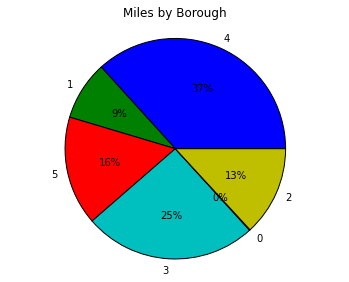

In [68]:
df = query_to_table(db,"""
                    select lboro as Borough, sum(st_length(geom))/5280 as Miles from (
                        select distinct on (segmentid) lboro, geom from {0}
                        where exclude = 0
                            and mft is not null
                        group by segmentid, geom, lboro
                    ) as singles group by lboro """.format(params.LION))

cols = ['borough', 'miles']
df = pd.DataFrame(df.to_dict(), columns=cols) # convert to pandas dataframe
#print df

labels = df['borough']
sizes = df['miles']


fig1, ax1 = plt.subplots()
ax1.set_title('Miles by Borough\n')
ax1.pie(sizes, labels=labels, autopct='%1.0f%%')#, startangle=70)
ax1.axis('equal')  

plt.show()
